In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from tensorflow import keras

In [7]:
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"train samples: {len(os.listdir(TRAIN_SAMPLE_FOLDER))}")
print(f"test samples: {len(os.listdir(TEST_FOLDER))}")

train samples: 401
test samples: 400


In [8]:
train_sample_metadata = pd.read_json('train_sample_videos/metadata.json').T
train_sample_metadata.head()

label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4

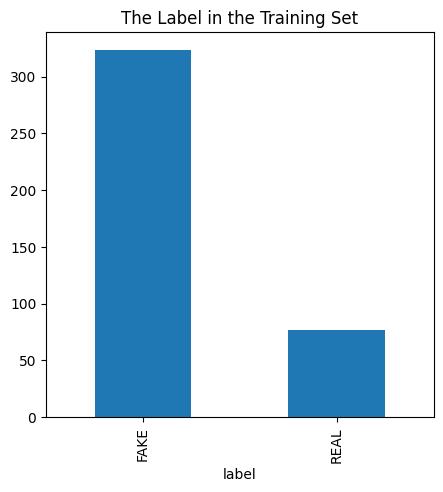

In [9]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(5,5),kind='bar',title='The Label in the Training Set')
plt.show()

In [10]:
train_sample_metadata.shape

(400, 3)

In [11]:
f_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].sample(5).index)
f_train_sample_video

['dakqwktlbi.mp4',
 'dtocdfbwca.mp4',
 'eixwxvxbbn.mp4',
 'dntkzzzcdh.mp4',
 'avgiuextiz.mp4']

In [12]:
def capture_image_from_video(video_path):
    # Capture video
    capture_image = cv2.VideoCapture(video_path)
    ret, frame = capture_image.read()
    
    if not ret:
        print(f"Could not read frame from {video_path}")
        return
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)  
    ax.imshow(frame)
    plt.show()
    capture_image.release()

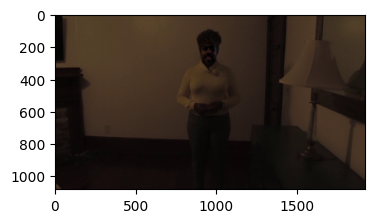

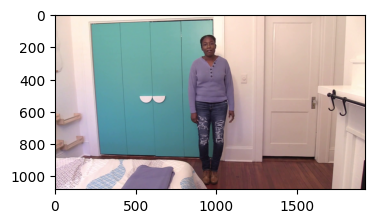

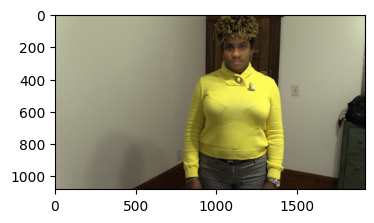

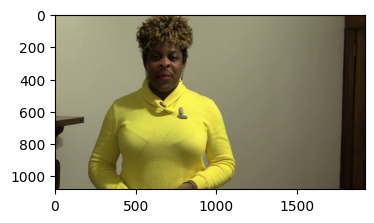

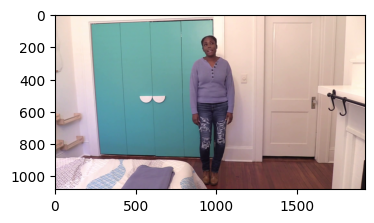

In [13]:
for video_file in f_train_sample_video:
    capture_image_from_video(os.path.join(TRAIN_SAMPLE_FOLDER, video_file))

In [14]:
r_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='REAL'].sample(5).index)
r_train_sample_video

['ajqslcypsw.mp4',
 'eggbjzxnmg.mp4',
 'avmjormvsx.mp4',
 'eudeqjhdfd.mp4',
 'ecujsjhscd.mp4']

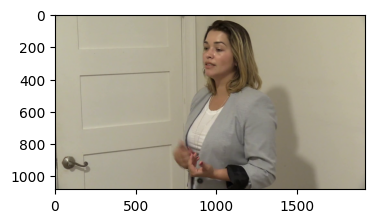

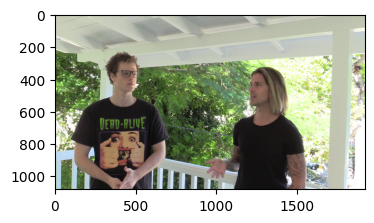

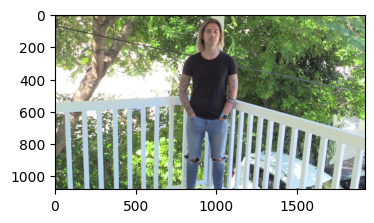

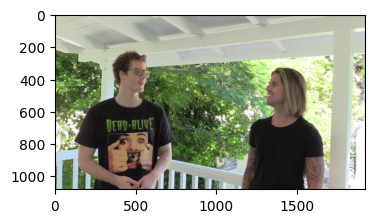

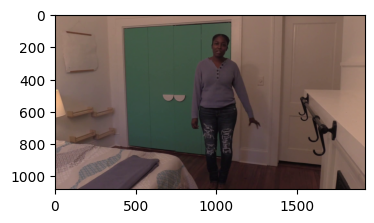

In [15]:
for video_file in r_train_sample_video:
    capture_image_from_video(os.path.join(TRAIN_SAMPLE_FOLDER,video_file))

In [16]:
f_videos = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].index)

In [17]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file,subset=TRAIN_SAMPLE_FOLDER):
    video_url = open(os.path.join(subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" %data_url)
play_video(f_videos[5])

In [18]:
img_size = 224
batch_size = 64
epochs = 15

max_seq_length = 20
num_features = 2048

In [19]:
def crop_center_square(frame):
    y,x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y :start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(img_size, img_size)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while 1:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [20]:
def pretrain_feature_extractor():
    feature_extractor = tf.keras.applications.InceptionV3(
    weights = "imagenet",
    include_top=False,
    pooling="avg",
    input_shape = (img_size,img_size,3)
    )
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
    
    inputs = tf.keras.Input((img_size,img_size,3))
    preprocessed = preprocess_input(inputs)
    
    outputs = feature_extractor(preprocessed)
    return tf.keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = pretrain_feature_extractor()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 161s 2us/step


In [21]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = list(df.index)
    labels = df["label"].values
    labels = np.array(labels=='FAKE').astype(int)
    
    frame_masks = np.zeros(shape=(num_samples, max_seq_length), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, max_seq_length, num_features), dtype="float32" 
    )
    
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        
        temp_frame_mask = np.zeros(shape=(1, max_seq_length,), dtype="bool")
        temp_frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")
        
        for i, batch in enumerate(frames):
            video_length = batch.shape[0] 
            length = min(max_seq_length, video_length) #if length is over 20s ,only cut 20s
            for j in range(length):
                temp_frame_features[i, j, :] =feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] =1 # 1 = not masked, 0 = masked ->give 1 when there are images ,otherwise 0 for padding
        
        frame_features[idx,] =temp_frame_features.squeeze() #squeeze array for training
        frame_masks[idx,] =temp_frame_mask.squeeze()
    
    return (frame_features, frame_masks), labels

In [22]:
from sklearn.model_selection import train_test_split

Train_set , Test_set = train_test_split(train_sample_metadata, test_size=0.1,random_state=42,
                                       stratify=train_sample_metadata['label'])
print(Train_set.shape, Test_set.shape)

(360, 3) (40, 3)


In [23]:
train_data, train_labels = prepare_all_videos(Train_set, "train")
test_data, test_labels = prepare_all_videos(Test_set, "test")

print(f"Frame features in train set:{train_data[0].shape}")
print(f"Frame masks in train set:{train_data[1].shape}")

Frame features in train set:(360, 20, 2048)
Frame masks in train set:(360, 20)


In [24]:
frame_features_input = keras.Input((max_seq_length, num_features))
mask_input = keras.Input((max_seq_length,),dtype="bool")

x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask = mask_input)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model([frame_features_input, mask_input], output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 20, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 20, 16)    │     99,168 │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 8)         │        624 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8)         │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         72 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          9 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,873 (390.13 KB)

 Trainable params: 99,873 (390.13 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
checkpoint = keras.callbacks.ModelCheckpoint(
    './model_checkpoint.weights.h5',  # Add a valid file name ending with `.weights.h5`
    save_weights_only=True,
    save_best_only=True
)
history = model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([test_data[0], test_data[1]], test_labels),
        callbacks=[checkpoint],
        epochs=epochs,
        batch_size=8
)

Epoch 1/15


c:\Users\91898\Desktop\Deepfake\venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_316', 'keras_tensor_317']. Received: the structure of inputs=('*', '*')
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7203 - loss: 0.6900 - val_accuracy: 0.8000 - val_loss: 0.6806
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7691 - loss: 0.6790 - val_accuracy: 0.8000 - val_loss: 0.6693
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8153 - loss: 0.6650 - val_accuracy: 0.8000 - val_loss: 0.6583
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8044 - loss: 0.6552 - val_accuracy: 0.8000 - val_loss: 0.6482
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7882 - loss: 0.6477 - val_accuracy: 0.8000 - val_loss: 0.6386
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7924 - loss: 0.6377 - val_accuracy: 0.8000 - val_loss: 0.6294
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8023 - loss: 0.6266 - val_accuracy: 0.8000 - val_loss: 0.6207
Epoch 8/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8047 - loss: 0.6174 - val_accuracy: 0.8000 - val_loss: 0.

In [26]:
test_videos = pd.DataFrame(list(os.listdir(os.path.join( TEST_FOLDER))), columns=['video'])

In [27]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, max_seq_length,), dtype="bool")
    frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(max_seq_length, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

def sequence_prediction(path):
    frames = load_video(os.path.join(TEST_FOLDER,path))
    frame_features, frame_mask = prepare_single_video(frames)
    return model.predict([frame_features, frame_mask])[0]
    
# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_videos["video"].values.tolist())
print(f"Test video path: {test_video}")

if(sequence_prediction(test_video)>=0.5):
    print(f'The predicted class of the video is FAKE')
else:
    print(f'The predicted class of the video is REAL')

play_video(test_video,TEST_FOLDER)

Test video path: zuwwbbusgl.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
The predicted class of the video is FAKE


In [28]:
# Save the trained model
model.save('deepfake_detection_model.h5')
print("Model saved as 'deepfake_detection_model.h5'")

Model saved as 'deepfake_detection_model.h5'


In [ ]:
# # Test the model
# test_loss, test_accuracy = model.evaluate(test_data, test_labels)
# print(f"Test Accuracy: {test_accuracy:.2f}")
# print(f"Test Loss: {test_loss:.2f}")

# # Example prediction on test data
# predictions = model.predict(test_data[:5])
# for i, pred in enumerate(predictions):
#     print(f"Video {i+1}: Predicted - {'FAKE' if pred[0] > 0.5 else 'REAL'}, True - {'FAKE' if test_labels[i] == 1 else 'REAL'}")